In [1]:
import pandas as pd
import psycopg2

In [3]:
pip install psycopg2-binary

Note: you may need to restart the kernel to use updated packages.


In [2]:
DBNAME = "opportunity_youth"

In [3]:
conn = psycopg2.connect(dbname=DBNAME)
cursor = conn.cursor()
cursor.execute("""SELECT table_name FROM information_schema.tables
       WHERE table_schema = 'public'""")
tables = []
for table in cursor.fetchall():
    tables.append(table[0])
tables

['pums_2017',
 'puma_names_2010',
 'wa_jobs_2017',
 'wa_geo_xwalk',
 'ct_puma_xwalk']

In [4]:
pums_2017_df = pd.read_sql("SELECT * FROM pums_2017;", conn)
puma_names_2010_df = pd.read_sql("SELECT * FROM puma_names_2010;", conn)
wa_jobs_2017_df = pd.read_sql("SELECT * FROM wa_jobs_2017;", conn)
wa_geo_xwalk_df = pd.read_sql("SELECT * FROM wa_geo_xwalk;", conn)
ct_puma_xwalk_df = pd.read_sql("SELECT * FROM ct_puma_xwalk;", conn)

In [5]:
df_new = pd.read_sql("""
SELECT sporder, puma, agep, cow, wkl, sch, schl, rt
FROM pums_2017
WHERE (agep BETWEEN 16.0 AND 24.9)
AND CAST(sch AS int) = 1
AND CAST(cow AS int) = 9
""", conn)
df_new


,sporder,puma,agep,cow,wkl,sch,schl,rt
0,02,10502,23.0,9,3,1,13,P
1,02,11503,19.0,9,3,1,16,P
2,02,11503,24.0,9,3,1,22,P
3,02,10502,19.0,9,3,1,16,P
4,03,10400,19.0,9,3,1,16,P
...,...,...,...,...,...,...,...,...
269,04,11103,23.0,9,3,1,21,P
270,01,11605,23.0,9,3,1,19,P
271,02,10503,18.0,9,3,1,16,P
272,06,11505,21.0,9,3,1,13,P


In [12]:
#pums_2017_df.shape

(359075, 286)

In [13]:
#print(pums_2017_df.cow.dtype)

object


In [14]:
#df_new.info

<bound method DataFrame.info of     sporder   puma  agep cow wkl sch schl rt
0        02  10502  23.0   9   3   1   13  P
1        02  11503  19.0   9   3   1   16  P
2        02  11503  24.0   9   3   1   22  P
3        02  10502  19.0   9   3   1   16  P
4        03  10400  19.0   9   3   1   16  P
..      ...    ...   ...  ..  ..  ..  ... ..
269      04  11502  20.0   9   3   1   16  P
270      01  11605  23.0   9   3   1   19  P
271      04  11103  23.0   9   3   1   21  P
272      06  11505  21.0   9   3   1   13  P
273      02  11608  21.0   9   3   1   21  P

[274 rows x 8 columns]>

In [15]:
#df_new.cow.isna().sum()

0

In [6]:
#list of Employment Status (COW), School Status(SCH), NWAV (Availble for work), NWAB (Temporary absence)
#NWLA (On lay off), NLWK (Looking for work).
#Table to view NULL values, to allow us to add filters to include more people.
df_cs = pd.read_sql("""
SELECT cow, sch, nwav, nwab, nwla, nwlk
FROM pums_2017
;""", conn)
df_cs

,cow,sch,nwav,nwab,nwla,nwlk
0,None,1,5,2,2,2
1,None,1,5,2,2,2
2,None,1,5,2,2,2
3,None,1,5,2,2,2
4,1,1,5,3,3,3
...,...,...,...,...,...,...
359070,5,1,5,3,3,3
359071,1,3,5,3,3,3
359072,1,2,5,2,2,2
359073,None,1,5,2,2,2


In [7]:
#df_cs.describe()

,cow,sch,nwav,nwab,nwla,nwlk
count,215545,347443,291865,291865,291865,291865
unique,9,3,5,3,3,3
top,1,1,5,3,3,3
freq,132602,264532,266800,172064,166563,172483


In [92]:
# puma_test = pd.read_sql(
# """ SELECT puma, puma_name
# FROM puma_names_2010
# WHERE state_name LIKE 'Washington%' AND puma_name LIKE 'King County%'
# """, conn)
# puma_test

,puma,puma_name
0,11606,"King County (Northwest)--Shoreline, Kenmore & ..."
1,11607,"King County (Northwest)--Redmond, Kirkland Cit..."
2,11608,King County (Northwest Central)--Greater Belle...
3,11609,"King County (Central)--Sammamish, Issaquah, Me..."
4,11610,"King County (Central)--Renton City, Fairwood, ..."
5,11613,King County (Southwest Central)--Kent City ...
6,11614,King County (Southwest)--Auburn City & Lakelan...
7,11615,"King County (Southeast)--Maple Valley, Covingt..."
8,11616,"King County (Northeast)--Snoqualmie City, Cott..."
9,11611,"King County (West Central)--Burien, SeaTac, Tu..."


In [9]:
#puma_test.describe()

,puma,puma_name
count,11,11
unique,11,11
top,11615,"King County (Central)--Renton City, Fairwood, ..."
freq,1,1


In [93]:
# List of total pop in south king county between 16 and 24.9
total_kids = pd.read_sql("""
SELECT A.puma, agep
FROM pums_2017 A
JOIN puma_names_2010 B ON A.puma = B.puma
WHERE state_name LIKE 'Washington%' AND puma_name LIKE 'King County%' AND puma_name LIKE '%South%'
AND (agep BETWEEN 16.0 AND 24.9)
""", conn)

In [94]:
# List of working kids without a HS diploma or GED
#WIP WORKING LIST
working_wodip = pd.read_sql ("""
SELECT A.puma, agep, schl
FROM pums_2017 A
JOIN puma_names_2010 B ON A.puma = B.puma
WHERE state_name LIKE 'Washington%' AND puma_name LIKE 'King County%' AND puma_name LIKE '%South%'
AND (agep BETWEEN 16.0 AND 24.9)
""", conn)
working_wodip

,puma,agep,schl
0,11606,21.0,19
1,11606,21.0,16
2,11612,19.0,18
3,11613,17.0,13
4,11614,17.0,12
...,...,...,...
2873,11613,18.0,11
2874,11606,18.0,18
2875,11606,18.0,18
2876,11606,18.0,19


In [142]:
#df_cs, but with filters. Having issues with NWAB/NWLA/NWLK setting them to = 1 OR 3
#Kids between 16 and 24.9 in South King County that are not working

puma_df_piv = pd.read_sql("""
SELECT A.puma, sporder, serialno, sch, schl, esr, cow, agep, pwgtp
FROM pums_2017 A
JOIN puma_names_2010 B ON A.puma = B.puma
WHERE state_name LIKE 'Washington%' AND puma_name LIKE 'King County%' AND puma_name LIKE '%South%'
AND (agep BETWEEN 16.0 AND 24.9)
""", conn)
puma_df_piv
#OR CAST(wkexrel as int) = (7 OR 8 OR 9 OR 12 OR 15)
#JOIN puma_names_2010 B ON A.puma = B.puma
#OR CAST(nwab as int) = 3
#OR CAST(nwla as int) = 3
#OR CAST(nwlk as int) = 3)

,puma,sporder,serialno,sch,schl,esr,cow,agep,pwgtp
0,11606,01,2013000003218,3,19,1,1,21.0,14.0
1,11606,02,2013000003218,1,16,1,1,21.0,15.0
2,11612,02,2013000007063,2,18,6,None,19.0,30.0
3,11613,02,2013000008046,2,13,6,None,17.0,36.0
4,11614,02,2013000011255,2,12,6,None,17.0,13.0
...,...,...,...,...,...,...,...,...,...
2873,11606,01,2017001511157,2,18,6,1,18.0,1.0
2874,11613,01,2017001518359,1,11,6,1,18.0,20.0
2875,11606,01,2017001526134,2,18,3,1,18.0,1.0
2876,11613,01,2017001530818,1,21,1,1,23.0,26.0


In [96]:
#NAN Count for puma_df_piv
#len(puma_df_piv) - puma_df_piv.count()

In [97]:
#puma_df_piv.loc[(puma_df_piv > 15.9 & puma_df_piv < 18.1), "AgeGroup"] = "16 - 18"

In [98]:
#true or false for age groups
# puma_df_piv["group_one"] = puma_df_piv.agep.between(15.9, 18.9)
# puma_df_piv["group_two"] = puma_df_piv.agep.between(19.0, 21.9)
# puma_df_piv["group_three"] = puma_df_piv.agep.between(22.0, 24.9)

In [99]:
# for x in puma_df_piv.group_one:
#     if x is True:
#         puma_df_piv["AgeGroup"] = "16-18"
#     else puma_df_piv["AgeGroup"] = "0"
#     elif x in puma_df_piv.group_two:
#         if x is True:
#             puma_df_piv["AgeGroup"] = "19-21"
#     elif x in puma_df_piv.group_three:
#         if x is True:
#             puma_df_piv["AgeGroup"] = "22-24"

#df_puma_test = puma_df_piv[puma_df_piv["group_one"]]["AgeGroup"] = "16-18"
# puma_df_piv[puma_df_piv.loc["group_two"]]['AgeGroup'] = "19-21"
# puma_df_piv[puma_df_piv.loc["group_three"]]['AgeGroup'] = "22-24"

In [100]:
#puma_df_piv[puma_df_piv.loc["group_one"]]
#puma_df_piv[puma_df_piv['group_one']]['AgeGroup'].values = '16-18'

In [101]:
puma_df_piv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2878 entries, 0 to 2877
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   puma      2878 non-null   object 
 1   sporder   2878 non-null   object 
 2   serialno  2878 non-null   object 
 3   sch       2878 non-null   object 
 4   schl      2878 non-null   object 
 5   esr       2878 non-null   object 
 6   cow       2002 non-null   object 
 7   agep      2878 non-null   float64
dtypes: float64(1), object(7)
memory usage: 180.0+ KB


In [102]:
#Code that adds Age_Group and groups ages into bins
puma_df_piv['Age_Group'] = pd.cut(x=puma_df_piv['agep'], bins=[16, 18, 21, 24], labels=['16-18', '19-21', '21-24'])

In [103]:
#Lists School Level Reached
# def school_range (schl):
#     if int(schl) < 15: return "No diploma"
#     elif int(schl) < 17: return "HS diploma or GED"
#     elif int(schl) < 19: return "Some College, no degree"
#     elif int(schl) < 25: return "Degree (Associate or higher)"
#     else: return "Unknown"
# puma_df_piv["School_Level"]= puma_df_piv.schl.apply(school_range)
# puma_df_piv

In [104]:
#adds columns School_Level which returns the level of education as a string
group_ed_df = puma_df_piv.groupby(by="School_Level").count()
group_ed_df = puma_df_piv[puma_df_piv.groupby(by="School_Level").count()

SyntaxError: unexpected EOF while parsing (<ipython-input-104-1d04d1d721ad>, line 3)

In [105]:
#Drops cow
#group_ed_df.drop("cow", axis=1)

In [106]:
#Lists School Level Reached
def school_range (schl):
    if int(schl) < 15: return "No diploma"
    elif int(schl) < 17: return "HS diploma or GED"
    elif int(schl) < 19: return "Some College, no degree"
    elif int(schl) < 25: return "Degree (Associate or higher)"
    else: return "Unknown"
puma_df_piv["School_Level"]= puma_df_piv.schl.apply(school_range)
puma_df_piv

,puma,sporder,serialno,sch,schl,esr,cow,agep,Age_Group,School_Level
0,11606,01,2013000003218,3,19,1,1,21.0,19-21,Degree (Associate or higher)
1,11606,02,2013000003218,1,16,1,1,21.0,19-21,HS diploma or GED
2,11612,02,2013000007063,2,18,6,None,19.0,19-21,"Some College, no degree"
3,11613,02,2013000008046,2,13,6,None,17.0,16-18,No diploma
4,11614,02,2013000011255,2,12,6,None,17.0,16-18,No diploma
...,...,...,...,...,...,...,...,...,...,...
2873,11606,01,2017001491175,2,20,6,None,19.0,19-21,Degree (Associate or higher)
2874,11613,01,2017001530818,1,21,1,1,23.0,21-24,Degree (Associate or higher)
2875,11613,01,2017001518359,1,11,6,1,18.0,16-18,No diploma
2876,11606,01,2017001526134,2,18,3,1,18.0,16-18,"Some College, no degree"


In [90]:
puma_df_piv

,puma,sporder,serialno,sch,schl,esr,cow,agep,Age_Group,School_Level,OY_Status,Total_Populations_Sch,Total_Populations,OY_Status_Counts
0,11606,01,2013000003218,3,19.0,1,1,21.0,19-21,Degree (Associate or higher),Working without Diploma,1708.0,1708.0,2985
1,11606,02,2013000003218,1,16.0,1,1,21.0,19-21,HS diploma or GED,Working without Diploma,1708.0,1708.0,2985
2,11608,03,2013000003370,2,18.0,6,3,18.0,16-18,"Some College, no degree",Not Opportunity Youth,1638.0,1638.0,2619
3,11610,01,2013000003570,1,21.0,1,1,24.0,21-24,Degree (Associate or higher),Working without Diploma,1935.0,1935.0,2985
4,11610,02,2013000003570,1,21.0,1,1,24.0,21-24,Degree (Associate or higher),Working without Diploma,1935.0,1935.0,2985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6193,11607,01,2017001523009,2,16.0,1,1,21.0,19-21,HS diploma or GED,Working without Diploma,1708.0,1708.0,2985
6194,11606,01,2017001530240,2,19.0,1,1,18.0,16-18,Degree (Associate or higher),Working without Diploma,1638.0,1638.0,2985
6195,11606,01,2017001526134,2,18.0,3,1,18.0,16-18,"Some College, no degree",Not Opportunity Youth,1638.0,1638.0,2619
6196,11607,01,2017001532535,2,16.0,6,1,19.0,19-21,HS diploma or GED,Not Opportunity Youth,1708.0,1708.0,2619


In [107]:
#TEST WITH ONE VARIABLE ESR

#Opportunity Youth - ESR = 3, 6, sch = 1
#Working without diploma - ESR = 1, 2, 4, 5, schl =< 15
#Not Opportunity Youth- ELSE
# def Y_Status (esr):
#     if (int(esr) == 3 or int(esr) == 6): return "Not Working"
#     elif (int(esr) == 1 or int(esr) == 2 or int(esr) == 4 or int(esr) == 5): return "Working"
#     else: return "):"
# puma_df_piv["Work_Status"] = puma_df_piv["esr", "sch"].apply(Y_Status)
#and int(sch) == 1: return "Opportunity Youth"
#and int(sch) <= 15: return "Working without diploma"
#and int(sch) == 1
#and int(sch) <= 15

 CODE TO ADD OY_STATUS FOR PIVOT

In [108]:
#Code to add OY_Status, for pivot grouping

def Y_Status (esr, sch):
    if (int(esr) == 3 or int(esr) == 6) and int(sch) == 1: return "Opportunity Youth"
    elif (int(esr) == 1 or int(esr) == 2 or int(esr) == 4 or int(esr) == 5) and int(sch) <= 15: return "Working without Diploma"
    else: return "Not Opportunity Youth"
puma_df_piv["OY_Status"] = puma_df_piv.apply(lambda x: Y_Status(x["esr"], x["sch"]), axis=1)

In [109]:
#puma_df_piv.drop(["group_one", "group_two", "group_three"], axis=1, inplace=True)

In [110]:
puma_df_piv.groupby("OY_Status").count()

,puma,sporder,serialno,sch,schl,esr,cow,agep,Age_Group,School_Level
OY_Status,,,,,,,,,,
Not Opportunity Youth,1158,1158,1158,1158,1158,1158,390,1158,817,1158
Opportunity Youth,307,307,307,307,307,307,199,307,294,307
Working without Diploma,1413,1413,1413,1413,1413,1413,1413,1413,1365,1413


In [111]:
puma_df_piv.sch.value_counts()

2    1571
1    1133
3     174
Name: sch, dtype: int64

In [112]:
puma_df_piv2 = puma_df_piv

In [113]:
#adds Total_Population_School for the second pivot
puma_df_piv2["Total_Populations_Sch"]=puma_df_piv2.groupby("Age_Group")["Age_Group"].transform("count")
#puma_df_piv2["School_Level"]=puma_df_piv2.groupby("School_Level")["School_Level"].transform("count")

In [114]:
#type(puma_df_piv2)

In [115]:
puma_df_piv2.groupby("School_Level").count()

,puma,sporder,serialno,sch,schl,esr,cow,agep,Age_Group,OY_Status,Total_Populations_Sch
School_Level,,,,,,,,,,,
Degree (Associate or higher),841,841,841,841,841,841,746,841,841,841,841
HS diploma or GED,730,730,730,730,730,730,594,730,726,730,726
No diploma,987,987,987,987,987,987,390,987,595,987,595
"Some College, no degree",320,320,320,320,320,320,272,320,314,320,314


In [116]:
#adds Total_Population column that takes the total population of each age group
puma_df_piv["Total_Populations"]=puma_df_piv.groupby("Age_Group")["Age_Group"].transform("count")
puma_df_piv["OY_Status_Counts"]=puma_df_piv.groupby("OY_Status")["OY_Status"].transform("count")

In [125]:
#count of sub group / total of age group
#puma_df_piv["Sub_Populations"]=puma_df_piv.group

In [118]:
puma_df_piv.groupby("Age_Group").count()

,puma,sporder,serialno,sch,schl,esr,cow,agep,School_Level,OY_Status,Total_Populations_Sch,Total_Populations,OY_Status_Counts
Age_Group,,,,,,,,,,,,,
16-18,719,719,719,719,719,719,370,719,719,719,719,719,719
19-21,867,867,867,867,867,867,712,867,867,867,867,867,867
21-24,890,890,890,890,890,890,819,890,890,890,890,890,890


CODE FOR CREATING A PIVOT TABLE FOR SCHOOL_LEVEL

In [134]:
puma_df_piv2.sort_values(["School_Level"])
grouper = puma_df_piv.groupby(["Age_Group", "School_Level"])["Total_Populations_Sch"].count()
print(grouper)
grouper = puma_df_piv.groupby(["Age_Group", "School_Level"], as_index=False).count()

Age_Group  School_Level                
16-18      Degree (Associate or higher)     42
           HS diploma or GED               168
           No diploma                      467
           Some College, no degree          42
19-21      Degree (Associate or higher)    337
           HS diploma or GED               317
           No diploma                       71
           Some College, no degree         142
21-24      Degree (Associate or higher)    462
           HS diploma or GED               241
           No diploma                       57
           Some College, no degree         130
Name: Total_Populations_Sch, dtype: int64


In [137]:
sch_piv=grouper.pivot(index="School_Level", columns="Age_Group", values="Total_Populations")
sch_piv

Age_Group,16-18,19-21,21-24
School_Level,,,
Degree (Associate or higher),42,337,462
HS diploma or GED,168,317,241
No diploma,467,71,57
"Some College, no degree",42,142,130


In [127]:
puma_df_piv.groupby("OY_Status").count()

,puma,sporder,serialno,sch,schl,esr,cow,agep,Age_Group,School_Level,Total_Populations_Sch,Total_Populations,OY_Status_Counts
OY_Status,,,,,,,,,,,,,
Not Opportunity Youth,1158,1158,1158,1158,1158,1158,390,1158,817,1158,817,817,1158
Opportunity Youth,307,307,307,307,307,307,199,307,294,307,294,294,307
Working without Diploma,1413,1413,1413,1413,1413,1413,1413,1413,1365,1413,1365,1365,1413


In [75]:
#piv_new = puma_df_piv.drop(["sporder", "serialno", "sch", "esr", "cow", "agep", "puma", "schl"], axis=1, inplace=True)
#puma_df_piv["Percent"] = puma_df_piv["OY_Status_Counts"]/6197

CODE FOR CREATING A PIVOT TABLE FOR OY_STATUS

In [131]:
puma_df_piv.sort_values(["Age_Group"])
grouper = puma_df_piv.groupby(["Age_Group", "OY_Status"])["Total_Populations"].count()
#puma_df_piv.groupby(["Age_Group", "OY_Status"])["Total_Populations"].count().toframe(name="df_test")
#d2 = grouper['OY_Count'].count().to_frame(name = 'new_df').reset_index()
print(grouper)
grouper = puma_df_piv.groupby(["Age_Group", "OY_Status"], as_index=False).count()

Age_Group  OY_Status              
16-18      Not Opportunity Youth      479
           Opportunity Youth           35
           Working without Diploma    205
19-21      Not Opportunity Youth      243
           Opportunity Youth          112
           Working without Diploma    512
21-24      Not Opportunity Youth       95
           Opportunity Youth          147
           Working without Diploma    648
Name: Total_Populations, dtype: int64


In [131]:
grouper

,Age_Group,OY_Status,School_Level,Total_Populations,OY_Status_Counts,Percent,Percet
0,16-18,Not Opportunity Youth,1110,1110,1110,1110,1110
1,16-18,Opportunity Youth,63,63,63,63,63
2,16-18,Working without Diploma,465,465,465,465,465
3,19-21,Not Opportunity Youth,516,516,516,516,516
4,19-21,Opportunity Youth,210,210,210,210,210
5,19-21,Working without Diploma,982,982,982,982,982
6,21-24,Not Opportunity Youth,212,212,212,212,212
7,21-24,Opportunity Youth,303,303,303,303,303
8,21-24,Working without Diploma,1420,1420,1420,1420,1420


In [129]:
oy_piv=grouper.pivot(index="OY_Status", columns="Age_Group", values="Total_Populations")

In [130]:
oy_piv

Age_Group,16-18,19-21,21-24
OY_Status,,,
Not Opportunity Youth,479,243,95
Opportunity Youth,35,112,147
Working without Diploma,205,512,648


In [138]:
#new_df.pivot(index="OY_Status", columns="Age_Group")

In [139]:
#puma_df_piv.pivot(index="Age_Group", columns="Percent")

In [140]:
#new_order = puma_df_piv["School_Level", "OY_Status", "Age_Group", "Total_Populations", "OY_Status_Counts", "Percent"]
#puma_df_piv=puma_df_piv.reindex(columns=new_order)

In [141]:
#puma_df_piv.groupby("OY_Status").count().pivot(columns = "Age_Group")

EVERYTHING BELLOW THIS IS CHARTS

In [49]:
import matplotlib.pyplot as plt
from sklearn import linear_model

In [54]:
puma_chart = puma_df_piv
puma_chart['schl'] = puma_chart['schl'].astype(float)
puma_chart

,puma,sporder,serialno,sch,schl,esr,cow,agep,Age_Group,School_Level,OY_Status,Total_Populations_Sch,Total_Populations,OY_Status_Counts
0,11606,01,2013000003218,3,19.0,1,1,21.0,19-21,Degree (Associate or higher),Working without Diploma,1708.0,1708.0,2985
1,11606,02,2013000003218,1,16.0,1,1,21.0,19-21,HS diploma or GED,Working without Diploma,1708.0,1708.0,2985
2,11608,03,2013000003370,2,18.0,6,3,18.0,16-18,"Some College, no degree",Not Opportunity Youth,1638.0,1638.0,2619
3,11610,01,2013000003570,1,21.0,1,1,24.0,21-24,Degree (Associate or higher),Working without Diploma,1935.0,1935.0,2985
4,11610,02,2013000003570,1,21.0,1,1,24.0,21-24,Degree (Associate or higher),Working without Diploma,1935.0,1935.0,2985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6193,11607,01,2017001523009,2,16.0,1,1,21.0,19-21,HS diploma or GED,Working without Diploma,1708.0,1708.0,2985
6194,11606,01,2017001530240,2,19.0,1,1,18.0,16-18,Degree (Associate or higher),Working without Diploma,1638.0,1638.0,2985
6195,11606,01,2017001526134,2,18.0,3,1,18.0,16-18,"Some College, no degree",Not Opportunity Youth,1638.0,1638.0,2619
6196,11607,01,2017001532535,2,16.0,6,1,19.0,19-21,HS diploma or GED,Not Opportunity Youth,1708.0,1708.0,2619


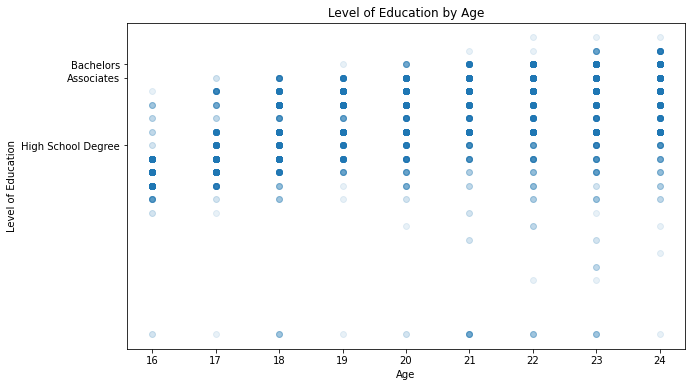

In [85]:
fig, ax = plt.subplots(figsize=(10, 6))
ax_scatter = plt.scatter(puma_chart.agep, puma_chart.schl, alpha=.1)
plt.title('Level of Education by Age')
plt.xlabel('Age')
plt.ylabel('Level of Education')
plt.yticks([15, 20, 21], ['High School Degree', 'Associates', 'Bachelors'])
plt.savefig('project_one_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
#WHERE state_name LIKE 'Washington%' AND puma_name LIKE 'King County%' AND puma_name LIKE '%South%'

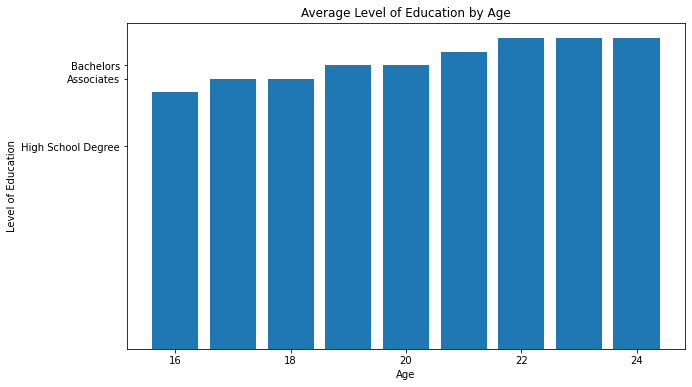

In [88]:
fig, ax = plt.subplots(figsize=(10, 6))
ax_bar = plt.bar(puma_chart.agep, puma_chart.schl)
plt.title('Average Level of Education by Age')
plt.xlabel('Age')
plt.ylabel('Level of Education')
plt.yticks([15, 20, 21], ['High School Degree', 'Associates', 'Bachelors'])
plt.savefig('project_one_bar.png', dpi=300, bbox_inches='tight')
plt.show()

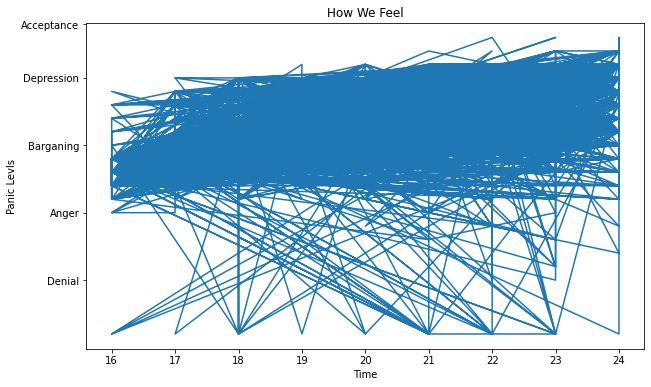

In [87]:
fig, ax = plt.subplots(figsize=(10, 6))
ax_stress = plt.plot(puma_chart.agep, puma_chart.schl)
plt.title('How We Feel')
plt.xlabel('Time')
plt.ylabel('Panic Levls')
plt.yticks([5, 10, 15, 20, 24], ['Denial', 'Anger', 'Barganing', 'Depression', 'Acceptance'])
plt.savefig('plot_stress.png', dpi=300, bbox_inches='tight')
plt.show()